# Data Fetching and Data Reducing

In [1]:
import os
import shutil
import random
import pandas as pd

In [ ]:
!unzip /kaggle/input/ifood-2019-fgvc6/train_set.zip -d train_set

Archive:  /kaggle/input/ifood-2019-fgvc6/train_set.zip
   creating: train_set/train_set/
  inflating: train_set/train_set/train_049346.jpg  
  inflating: train_set/train_set/train_050550.jpg  
  inflating: train_set/train_set/train_076858.jpg  
  inflating: train_set/train_set/train_060479.jpg  
  inflating: train_set/train_set/train_058545.jpg  
  inflating: train_set/train_set/train_051317.jpg  
  inflating: train_set/train_set/train_091600.jpg  
  inflating: train_set/train_set/train_085653.jpg  
  inflating: train_set/train_set/train_117416.jpg  
  inflating: train_set/train_set/train_071015.jpg  
  inflating: train_set/train_set/train_110462.jpg  
  inflating: train_set/train_set/train_009519.jpg  
  inflating: train_set/train_set/train_074181.jpg  
  inflating: train_set/train_set/train_080705.jpg  
  inflating: train_set/train_set/train_114687.jpg  
  inflating: train_set/train_set/train_040991.jpg  
  inflating: train_set/train_set/train_023661.jpg  
  inflating: train_set/trai

In [3]:
!unzip /kaggle/input/ifood-2019-fgvc6/val_set.zip -d test_set

Archive:  /kaggle/input/ifood-2019-fgvc6/val_set.zip
   creating: test_set/val_set/
  inflating: test_set/val_set/val_005718.jpg  
  inflating: test_set/val_set/val_002822.jpg  
  inflating: test_set/val_set/val_000473.jpg  
  inflating: test_set/val_set/val_002322.jpg  
  inflating: test_set/val_set/val_002341.jpg  
  inflating: test_set/val_set/val_012047.jpg  
  inflating: test_set/val_set/val_006172.jpg  
  inflating: test_set/val_set/val_006206.jpg  
  inflating: test_set/val_set/val_005053.jpg  
  inflating: test_set/val_set/val_010076.jpg  
  inflating: test_set/val_set/val_005872.jpg  
  inflating: test_set/val_set/val_007417.jpg  
  inflating: test_set/val_set/val_009937.jpg  
  inflating: test_set/val_set/val_004665.jpg  
  inflating: test_set/val_set/val_002195.jpg  
  inflating: test_set/val_set/val_007858.jpg  
  inflating: test_set/val_set/val_004747.jpg  
  inflating: test_set/val_set/val_001325.jpg  
  inflating: test_set/val_set/val_005756.jpg  
  inflating: test_set/v

In [4]:
import os
import shutil
import random
import pandas as pd

# Function to limit images per class
def limit_images_per_class(labels_df, source_dir, dest_dir, limit=200):
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)
    
    class_groups = labels_df.groupby('label')
    
    for label, group in class_groups:
        dest_class_dir = os.path.join(dest_dir, str(label))
        
        if not os.path.exists(dest_class_dir):
            os.makedirs(dest_class_dir)
        
        images = group['img_name'].tolist()
        selected_images = random.sample(images, min(limit, len(images)))
        
        for image_name in selected_images:
            source_image_path = os.path.join(source_dir, image_name)
            dest_image_path = os.path.join(dest_class_dir, image_name)
            shutil.copy(source_image_path, dest_image_path)


In [6]:
# Load the CSV files
train_labels = pd.read_csv('/kaggle/input/ifood-2019-fgvc6/train_labels.csv')
test_labels = pd.read_csv('/kaggle/input/ifood-2019-fgvc6/val_labels.csv')
# Define source and destination directories
train_source_dir = '/kaggle/working/train_set/train_set'
test_source_dir = '/kaggle/working/test_set/val_set'
limited_train_dir = '/kaggle/working/limited_train_set'
limited_test_dir = '/kaggle/working/limited_test_set'

In [7]:
# Limit images per class for train and test sets
limit_images_per_class(train_labels, train_source_dir, limited_train_dir)
limit_images_per_class(test_labels, test_source_dir, limited_test_dir)
# Now train data has 100 images per class, validation has different number of images per class max 100

In [8]:
# Create train, test and validation data
# Directories
train_dir = '/kaggle/working/limited_train_set'  # Your directory containing 251 folders for training
val_dir = '/kaggle/working/limited_val_set'  # Directory to save validation data
test_dir = '/kaggle/working/limited_test_set'  # Your directory containing 251 folders for testing
# Create validation directory
#os.makedirs(val_dir)

In [9]:
import os
import shutil
import random
from sklearn.model_selection import train_test_split

# Function to split data into training and validation
def split_train_val(train_dir, val_dir, val_ratio=0.2):
    for class_name in os.listdir(train_dir):
        class_dir = os.path.join(train_dir, class_name)
        images = os.listdir(class_dir)
        
        train_images, val_images = train_test_split(images, test_size=val_ratio, random_state=42)
        
        val_class_dir = os.path.join(val_dir, class_name)
        if not os.path.exists(val_class_dir):
            os.makedirs(val_class_dir)
        
        for image in val_images:
            shutil.move(os.path.join(class_dir, image), os.path.join(val_class_dir, image))
# Perform the split
split_train_val(train_dir, val_dir)

# Data Augmentation

In [10]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.RandomCrop(224, padding=4),  # Add random crop with padding
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load datasets
data_dir = {
    'train': train_dir,
    'val': val_dir,
    'test':test_dir
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir[x]), data_transforms[x]) for x in ['train', 'val', 'test']}
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=32, shuffle=True, num_workers=4),
    'val': DataLoader(image_datasets['val'], batch_size=32, shuffle=False, num_workers=4),
    'test': DataLoader(image_datasets['test'], batch_size=32, shuffle=False, num_workers=4)
}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

print(f"Dataset sizes: {dataset_sizes}")


Dataset sizes: {'train': 40027, 'val': 10007, 'test': 11994}


# Define a CNN Has Less Than 1M Parameters

In [10]:
"""
import torch
import torch.nn as nn

# Define an even more compact CNN model
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),               
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),           
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(16 * 56 * 56, 16) ,                   
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(16, num_classes),                        
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
# Initialize the model, loss function, optimizer, and learning rate scheduler
model = CNN(num_classes=len(class_names))
"""

'\nimport torch\nimport torch.nn as nn\n\n# Define an even more compact CNN model\nclass CNN(nn.Module):\n    def __init__(self, num_classes):\n        super(CNN, self).__init__()\n        self.features = nn.Sequential(\n            nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),\n            nn.ReLU(inplace=True),\n            nn.MaxPool2d(kernel_size=2, stride=2),               \n            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1), \n            nn.ReLU(inplace=True),\n            nn.MaxPool2d(kernel_size=2, stride=2),           \n        )\n        self.classifier = nn.Sequential(\n            nn.Dropout(),\n            nn.Linear(16 * 56 * 56, 16) ,                   \n            nn.ReLU(inplace=True),\n            nn.Dropout(),\n            nn.Linear(16, num_classes),                        \n        )\n\n    def forward(self, x):\n        x = self.features(x)\n        x = x.view(x.size(0), -1)\n        x = self.classifier(x)\n        return x\n# Initialize the m

First Conv Layer: (3 * 3 * 3 * 8) + 8 = 224
Second Conv Layer: (3 * 3 * 8 * 16) + 16 = 1,168
First Fully Connected Layer: (16 * 56 * 56 * 16) + 16 = 802,768
Second Fully Connected Layer: (16 * 251) + 251 = 4,271
Total expected parameters: 
224 + 1,168 + 802 , 768 + 4,271 = 808,431

CNN with Global Average Pooling Instead of Fully Connected Layers

In [11]:
import torch
import torch.nn as nn

class CNN_Modified2(nn.Module):
    def __init__(self, num_classes):
        super(CNN_Modified2, self).__init__()
        self.features = nn.Sequential(          
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Conv2d(512, num_classes, kernel_size=1), 
            nn.AdaptiveAvgPool2d(1),  # Global average pooling
            nn.Flatten(),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Number of classes for classification
num_classes = 251

# Create the model
model = CNN_Modified2(num_classes)

# Move the model to the appropriate device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Check the number of parameters
num_params = sum(p.numel() for p in model.parameters())
print(f"Model has {num_params} parameters.")

Model has 961659 parameters.


# Training

In [12]:
NUM_EPOCHS = 80
NUM_CLASSES = len(class_names)

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import copy
import numpy as np

# Initialize the model, loss function, optimizer, and learning rate scheduler
model = CNN_Modified2(num_classes=NUM_CLASSES)
# Move the model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.CrossEntropyLoss()
# Use Adam optimizer with weight decay for regularization
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Use CosineAnnealingLR scheduler for learning rate adjustment
#scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)  # T_max is the number of epochs

# Train the model with early stopping
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            running_total = 0
            start_time = time.time()

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                running_total += inputs.size(0)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc.cpu())  # Move tensor to CPU
                #scheduler.step(epoch_loss)  # Pass the epoch loss to the scheduler

            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc.cpu())  # Move tensor to CPU

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val':
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1

                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    torch.save(model.state_dict(), 'best_model.pth')  # Save the best model

    model.load_state_dict(best_model_wts)
    return model, train_loss_history, val_loss_history, train_acc_history, val_acc_history

# Run the training
model, train_loss, val_loss, train_acc, val_acc = train_model(model, dataloaders, criterion, optimizer, num_epochs=NUM_EPOCHS)

Epoch 0/79
----------
train Loss: 5.4463 Acc: 0.0107
val Loss: 5.3135 Acc: 0.0184
Epoch 1/79
----------
train Loss: 5.2944 Acc: 0.0168
val Loss: 5.1217 Acc: 0.0308
Epoch 2/79
----------
train Loss: 5.1713 Acc: 0.0266
val Loss: 4.9918 Acc: 0.0404
Epoch 3/79
----------
train Loss: 5.0613 Acc: 0.0354
val Loss: 5.0049 Acc: 0.0392
Epoch 4/79
----------
train Loss: 4.9842 Acc: 0.0431
val Loss: 4.8202 Acc: 0.0543
Epoch 5/79
----------
train Loss: 4.8887 Acc: 0.0531
val Loss: 4.8012 Acc: 0.0613
Epoch 6/79
----------
train Loss: 4.7956 Acc: 0.0640
val Loss: 4.7038 Acc: 0.0755
Epoch 7/79
----------
train Loss: 4.7009 Acc: 0.0756
val Loss: 4.6484 Acc: 0.0842
Epoch 8/79
----------
train Loss: 4.6165 Acc: 0.0863
val Loss: 4.4307 Acc: 0.1184
Epoch 9/79
----------
train Loss: 4.5451 Acc: 0.0978
val Loss: 4.3623 Acc: 0.1211
Epoch 10/79
----------
train Loss: 4.4803 Acc: 0.1043
val Loss: 4.2717 Acc: 0.1391
Epoch 11/79
----------
train Loss: 4.4179 Acc: 0.1147
val Loss: 4.3445 Acc: 0.1249
Epoch 12/79
--

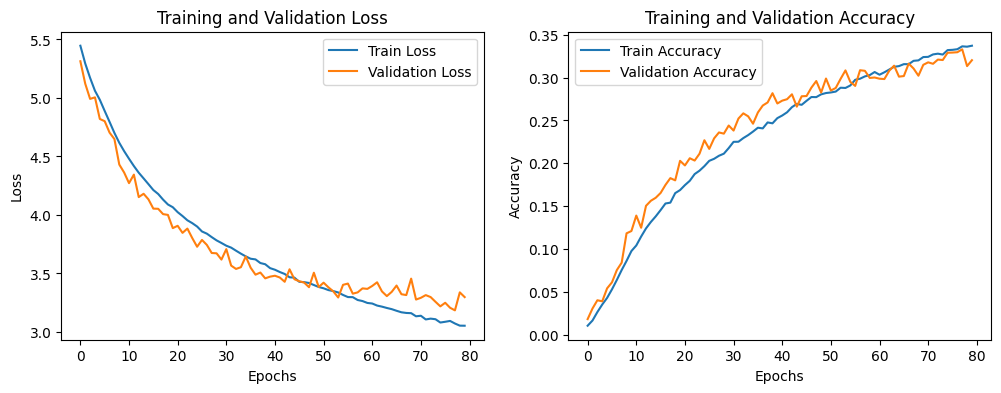

In [20]:
# Plotting the training and validation accuracy and loss outside the training function
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Testing

In [13]:
import torch
import torch.nn.functional as F
import time
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate_model(model, dataloader, device):
    model.load_state_dict(torch.load('/kaggle/input/best-cnn/best_model.pth'))
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    
    running_corrects = 0
    running_total = 0
    all_labels = []
    all_preds = []
    
    start_time = time.time()

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            running_corrects += torch.sum(preds == labels.data)
            running_total += inputs.size(0)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    accuracy = running_corrects.double() / running_total
    mce = 1 - accuracy
    throughput = running_total / (time.time() - start_time)
    
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f'Test Accuracy: {accuracy:.4f} MCE: {mce:.4f} Throughput: {throughput:.2f} images/sec')
    print(f'Precision: {precision:.4f} Recall: {recall:.4f} F1 Score: {f1:.4f}')

evaluate_model(model, dataloaders['test'], device)

Test Accuracy: 0.3948 MCE: 0.6052 Throughput: 894.75 images/sec
Precision: 0.4353 Recall: 0.3948 F1 Score: 0.3905
